
I have dowloaded the data from the [Kitchenware classification](https://www.kaggle.com/competitions/kitchenware-classification) competition on Kaggle.

To get started you need to download the kitchenware-classification.zip and extract it in the data subdirectory.

Now let's train a baseline model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras

2022-12-22 21:20:12.295112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 21:20:12.533635: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-22 21:20:12.533691: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-22 21:20:13.339080: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

First, we will load the training dataframe and split it into train and validation

In [2]:
df_train_full = pd.read_csv('data/train.csv', dtype={'Id': str})
df_train_full['filename'] = 'data/images/' + df_train_full['Id'] + '.jpg'
df_train_full.head()

,Id,label,filename
0,0560,glass,data/images/0560.jpg
1,4675,cup,data/images/4675.jpg
2,0875,glass,data/images/0875.jpg
3,4436,spoon,data/images/4436.jpg
4,8265,plate,data/images/8265.jpg


In [3]:
val_cutoff = int(len(df_train_full) * 0.8)
df_train = df_train_full[:val_cutoff]
df_val = df_train_full[val_cutoff:]

Now let's create image generators

In [4]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
)

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.


In [6]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)
base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(6)(vectors)

model = keras.Model(inputs, outputs)

2022-12-22 21:20:14.434163: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-22 21:20:14.434198: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-22 21:20:14.434225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu22): /proc/driver/nvidia/version does not exist
2022-12-22 21:20:14.434477: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [10]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [11]:
history = model.fit(
    train_generator,
    epochs=4,
    validation_data=val_generator,
    callbacks=[checkpoint]
)

Epoch 1/4
139/139 [==============================] - 457s 3s/step - loss: 0.7401 - accuracy: 0.8197 - val_loss: 0.6047 - val_accuracy: 0.8615
Epoch 2/4
139/139 [==============================] - 319s 2s/step - loss: 0.3467 - accuracy: 0.8957 - val_loss: 0.6500 - val_accuracy: 0.8615
Epoch 3/4
139/139 [==============================] - 307s 2s/step - loss: 0.2955 - accuracy: 0.9213 - val_loss: 0.8430 - val_accuracy: 0.8516
Epoch 4/4
139/139 [==============================] - 308s 2s/step - loss: 0.2263 - accuracy: 0.9339 - val_loss: 0.7351 - val_accuracy: 0.8678


Now let's use this model to predict the labels for test data

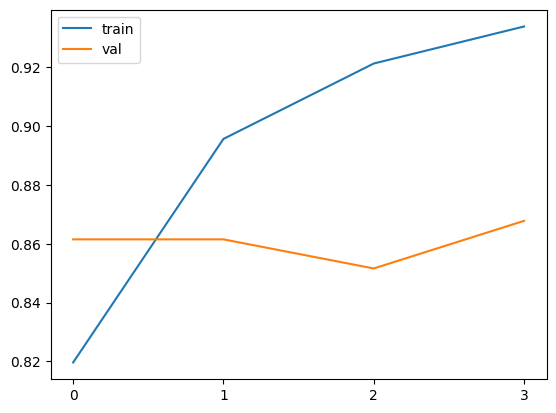

In [16]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(4))
plt.legend()

I am using the model from the last epoch because it has the highest accuracy.

# Using the model
* Loading the model
* Evaluating the model
* Getting predictions

In [17]:
import tensorflow as tf
from tensorflow import keras

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications.xception import preprocess_input

For quick testing we are using a cup

In [20]:
path = 'data/images/4138.jpg'

In [19]:
model = keras.models.load_model('xception_v1_04_0.868.h5')

In [21]:
img = load_img(path, target_size=(150, 150))

In [22]:
import numpy as np

In [23]:
x = np.array(img)
X = np.array([x])
X.shape

(1, 150, 150, 3)

In [24]:
X = preprocess_input(X)

In [25]:
pred = model.predict(X)

1/1 [==============================] - 1s 1s/step


In [26]:
classes = [
    'cups',
    'glasses',
    'plates',
    'spoons',
    'forks',
    'knifes'
]

In [27]:
dict(zip(classes, pred[0]))

{'cups': 8.462022,
 'glasses': -7.2444544,
 'plates': 2.0652041,
 'spoons': -24.173037,
 'forks': -3.7896435,
 'knifes': -14.585004}

We successfully detected the cup